In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xtrack as xt
import xobjects as xo
import scipy
import xpart as xp
from scipy.constants import c

In [2]:
import sympy as sy
# from sympy import init_session
# init_session() 

# Ring design

In [3]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 2*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

Given a magnetic field of $B$, the bending radius will be 

$$ \rho = p/q \frac{1}{B}$$

The angle of deflection will be the fraction of bending radius and length, approximately

$$\phi = \frac{L}{\rho}$$

If we assume a dipole length of $2$ meters, and a maximum dipole kicker field of $1$ T, we can get a bending angle of 

$$\phi = \frac{q}{p} L B $$

In [4]:
l_kicker = 2
b_kicker = 1
phi = l_kicker*b_kicker/(pc_GeV*1e9/c)
phi

0.029979245800000002

We can get a bending angle of almost $3$ mrad. For sake of simplicity, lets set $\phi = 1$ mrad.

To achieve a horizontal displacement of $\Delta x = 2$ mm, we then need a drift length of $l_{ramp} = 2$ m, as 

$$\Delta x = \phi \cdot l_{ramp}$$

In [5]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'qtrim_f': 0,
          'qtrim_d': 0,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo',
          "kick_angle" : -0.001 ,
          "kicker_length" : 2,
          "l_ramp" : 2,
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')
env.new('mb0', 'mb') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mb1', 'mb')

#env.new('kicker', xt.Bend, knl = ["kick_angle"], length = "kicker_length")
env.new('kicker', xt.Bend, k0 = "kick_angle/kicker_length", length = "kicker_length")
env.new('mk1', 'kicker') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk2', 'kicker',  k0 = "-kick_angle/kicker_length")
env.new('mk3', 'kicker',  k0 = "-kick_angle/kicker_length") #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk4', 'kicker')

env.vars({'ksf': 0.00, 'ksd' : 0.00 })

env.new('ms.f', xt.Multipole, knl = [0, 0, 'ksf'])
env.new('ms.d', xt.Multipole, knl = [0, 0, 'ksd'])

env.new('mq', xt.Quadrupole, length='lquad')

env.new('mq.f', 'mq', k1='k1f + qtrim_f')
env.new('mq.d', 'mq', k1='k1d + qtrim_d')

cell_moved_dipole = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

cell = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='0.25 * lfodo + lquad * 0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='0.75 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])
cell.insert_element('ms.f', at = 'mq.f')
cell.insert_element('ms.d', at = 'mq.d')

Baseline ring from exercise 3

In [6]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell)]*1+[env.place(cell)]*(number_of_FODO-1) )

(0.0, 50.0)

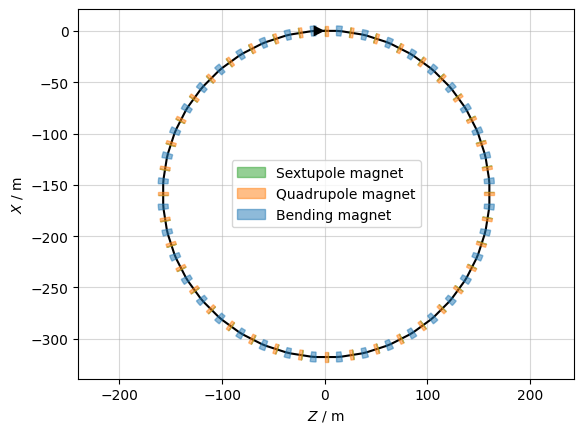

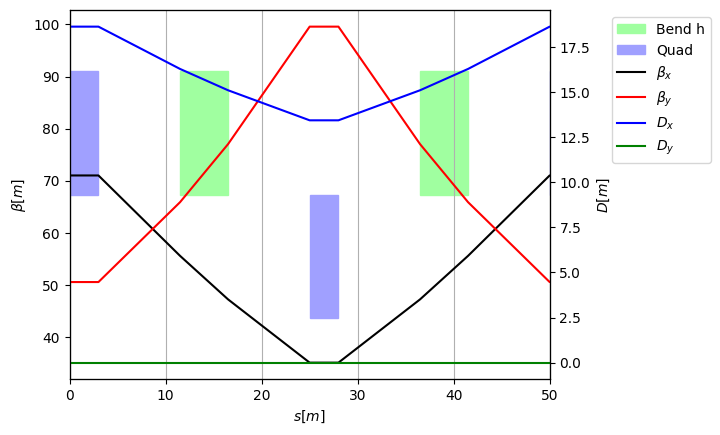

In [7]:
line.survey().plot()
line.twiss4d().plot()
plt.xlim(0,50)

We want to move the dipoles to the edges of the FODO cell to make room for the 4 kickers. In fact, let us do this!

In [8]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell_moved_dipole)]*1+[env.place(cell)]*(number_of_FODO-1) )

(0.0, 50.0)

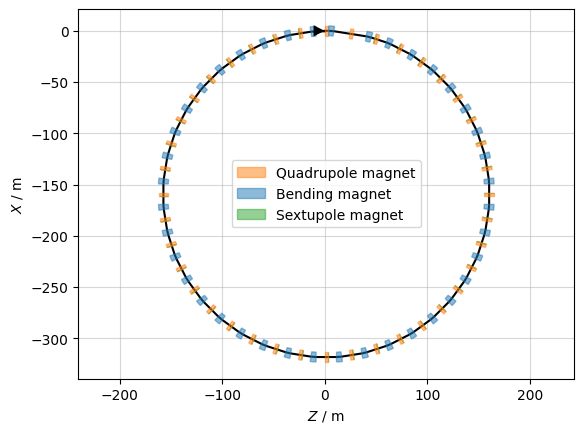

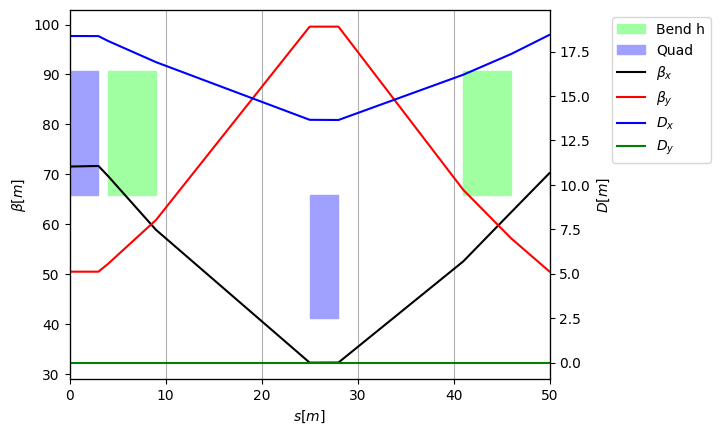

In [9]:
line.survey().plot()
line.twiss4d().plot()
plt.xlim(0,50)

In [10]:
line.to_pandas()[0:11]

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point,False,False,None,False,Marker(_dummy=0)
1,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=0)
2,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
3,3.0,Drift,drift_1,True,False,None,False,Drift(length=1)
4,4.0,Bend,mb0,True,False,None,False,"Bend(length=5, k0=0.0314, k1=0, h=0.0314, mode..."
5,9.0,Drift,drift_2,True,False,None,False,Drift(length=16)
6,25.0,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0098, k1s=0, length=3, num_mu..."
7,28.0,Drift,drift_3,True,False,None,False,Drift(length=13)
8,41.0,Bend,mb1,True,False,None,False,"Bend(length=5, k0=0.0314, k1=0, h=0.0314, mode..."
9,46.0,Drift,drift_4,True,False,None,False,Drift(length=4)


As we can see, there is now space between the Drift at **9 m**, and the quadrupole at **25 m**. Putting in a 1 m distance between dipole and the kickers, we can put them in. The total **16 m** of free space will be taken up by 

- 1 m safety distance
- 2 m kicker
- 2 m kicker
- 7 m drift space
- 2 m kicker
- 2 m kicker

In [11]:
cell_kick = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mk1', at='lbend + lquad + 1  + kicker_length/2'),
    env.place('mk2', at='lbend+ lquad + 1 +  l_ramp + kicker_length/2'),
    env.new("marker_extr", xt.Marker, at =  "lbend+ lquad + 1 +  l_ramp + kicker_length + 3.5"),
    env.place('mk3', at='lbend+ lquad + 1 + 15 - l_ramp - kicker_length/2'),
    env.place('mk4', at='lbend+ lquad + 1 + 15 - kicker_length/2'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

In [12]:
cell_kick.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=0)
1,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_9,True,False,None,False,Drift(length=1)
3,4.0,Bend,mb0,True,False,None,False,"Bend(length=5, k0=0.0314, k1=0, h=0.0314, mode..."
4,9.0,Bend,mk1,True,False,None,False,"Bend(length=2, k0=-0.0005, k1=0, h=0, model='a..."
5,11.0,Bend,mk2,True,False,None,False,"Bend(length=2, k0=0.0005, k1=0, h=0, model='ad..."
6,13.0,Drift,drift_10,True,False,None,False,Drift(length=3.5)
7,16.5,Marker,marker_extr,False,False,None,False,Marker(_dummy=0)
8,16.5,Drift,drift_11,True,False,None,False,Drift(length=3.5)
9,20.0,Bend,mk3,True,False,None,False,"Bend(length=2, k0=0.0005, k1=0, h=0, model='ad..."


(0.0, 50.0)

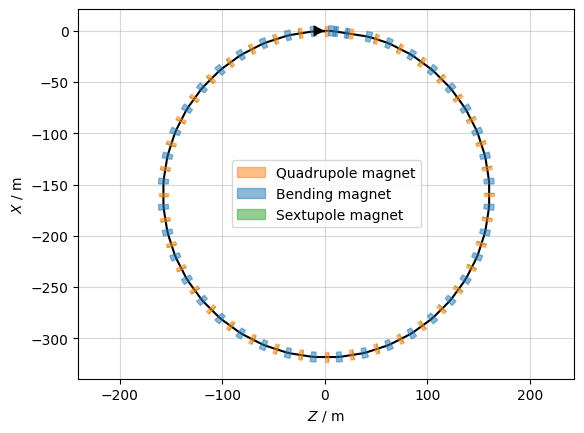

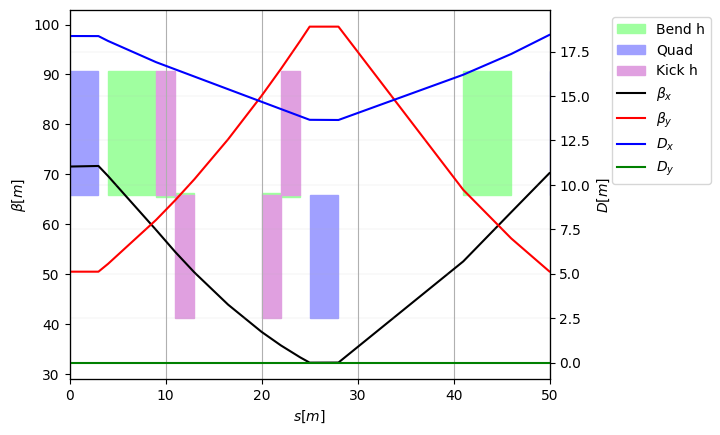

In [13]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell_kick)]*1+[env.place(cell)]*(number_of_FODO-1) )
line.survey().plot()
twiss = line.twiss4d()
twiss.plot()
plt.grid(linewidth = 0.1, which = "both")
plt.xlim(0,50)

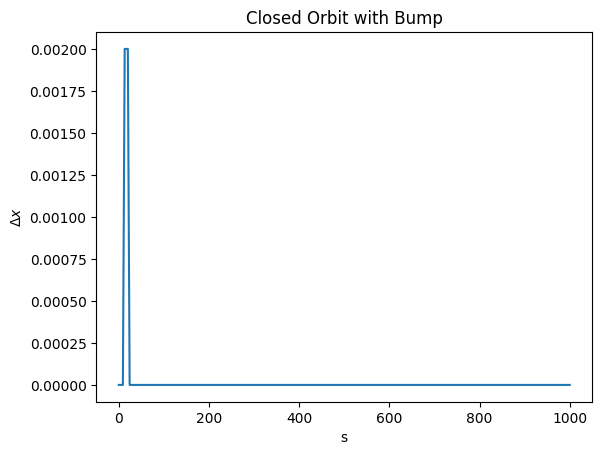

In [14]:
plt.plot(twiss.s, twiss.x)
plt.xlabel("s")
plt.ylabel(r"$\Delta x$")
plt.title("Closed Orbit with Bump")
plt.show()

## Tracking!

If we now track through the bump, we see that it works! However, the beam size is critical. If we want to extract at $\Delta x = 4$ mm and our closed orbit is on $\Delta x = 2$ mm, we do want the beam on the CO to be so large it gets distracted without the extra kick. Hence, we for simplicity, we want $4\sigma_x = 1$ mm.

At the extraction point $\bar s$, this means that the maximal emittance must be $$\epsilon = \frac{\sigma_x^2}{\beta(\bar s)}$$ 

In [15]:
(1e-3/4)**2*1/(twiss.rows["marker_extr"].betx)

array([1.42112915e-09])

Hence our horizontal emittance should be at most

$$\epsilon_{max} = 0.00142 \text{ mm mrad}$$

Clearly, this is way too little, and we need to reduce our beta function, i.e. increase our focusing! But our maximum focusing without increasing the number of FODOs and hence reduce our spacing in the dipoles is only a factor of 2 higher:

In [16]:
env['k1f'] = 0.02
env['k1d'] = -0.02

In [17]:
twiss_focused = line.twiss4d()
(1e-3/4)**2*1/(twiss_focused.rows["marker_extr"].betx)

array([2.33017582e-09])

This means we need more FODO cells and a straight section in which we can actually put the kickers, as the increase in FODO cells means a smaller cell at constant circumference. Which in turn means there is less space for the kickers.

Nonetheless, we can see what would happen if we had this small of an emittance!

Let us now build our particles!

In [18]:
twiss.beta0

0.9989013699982578

In [19]:
num_particles = 1000
nemitt_x = 1.4e-9/(twiss.beta0*twiss.gamma0)
nemitt_y = nemitt_x

x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(num_particles)
y_in_sigmas, py_in_sigmas = xp.generate_2D_gaussian(num_particles)
particles = line.build_particles(
            x_norm=x_in_sigmas, px_norm=px_in_sigmas,
            y_norm=y_in_sigmas, py_norm=py_in_sigmas,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y, method = "4d")

The line already has an associated tracker


(0.0, 50.0)

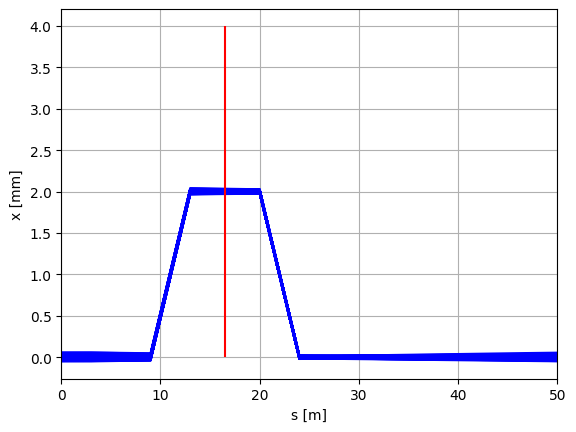

In [20]:
line.build_tracker() #generate tracker for original line (no dipolar kick!)

n_turns = 1
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
plt.plot(line.record_last_track.s.T, line.record_last_track.x.T*1e3, 'b')
plt.vlines(twiss.rows["marker_extr"].s, 0, 4, color = "red")
plt.grid()
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.xlim(0,50)

And in fact it looks good (in this theoretical case)!

# Making Space for the Kicker in the a straight Section

Let us change our lattice. If we impose a reasonable emittance of 

$$ 1 \text{mm mrad},$$

this means a $\beta_x = \sigma_x^2/\epsilon$ of 

In [21]:
(1e-3/4)**2*1/(1e-6/(twiss.gamma0*twiss.beta0))

1.3322361559861184

We want a $\beta_x = 1$ m, approximately

Now $\beta_{min}$ in a FODO lattice is

$$\beta_{max}=\frac{2 L}{\sin{\mu}}(1-\sin(\frac{\mu}{2}))$$

Assume $L_{min} = 16$ m due to having at least $2$ dipoles and $2$ quadrupoles, with a total length of 16 m

/var/folders/nl/1wb82bld4q50r2dck0b63_z00000gn/T/ipykernel_15156/863358232.py:3: RuntimeWarning: divide by zero encountered in divide
  beta_min = 2*L/np.sin(mu)*(1-np.sin(mu/2))


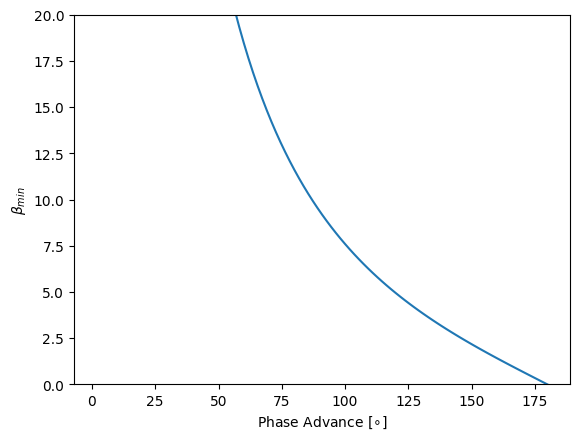

In [22]:
mu = np.linspace(0,np.pi,100)
L = 16
beta_min = 2*L/np.sin(mu)*(1-np.sin(mu/2))
plt.plot(mu/(2*np.pi)*360, beta_min)
plt.ylim(0,20)
plt.xlabel(r"Phase Advance [$\circ$]")
plt.ylabel(r"$\beta_{min}$")
plt.show()

And we see that even at minimal FODO length of $16$ m, the phase advance to get that small beam size at extraction would need to be $\mu \approx 175\deg$

# Extraction in Straight Sections

/Users/fstummer/venv/py311/lib/python3.11/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)


Matching: model call n. 119               



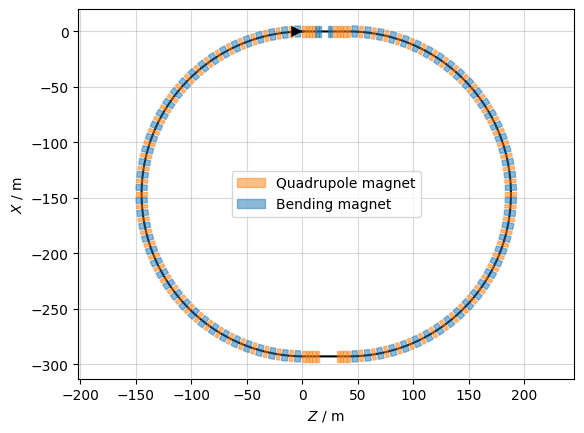

In [23]:
lss = 40
lquad = 3
lcirc = 1000 - 2*lss
number_of_fodo = 40
number_of_dipoles = number_of_fodo *2
l_fodo = lcirc/number_of_fodo
f = l_fodo/(2*np.sqrt(2))
k1 = 1/(f*lquad)
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'qtrim_f': 0,
          'qtrim_d': 0,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_fodo,
          'lfodo': 'lcirc/number_of_fodo',
          "kick_angle" : -0.001 ,
          "kicker_length" : 2,
          "l_ramp" : 2,
          "ext_kicker_angle": -0.0,
          "ext_kicker_length": 0.5,
          })
env['lsext'] = 0.5
env['k2f'] = 0
env['k2d'] = 0

env['lss'] = lss
env['f_ss'] = 2 #'lss / 2 '
env['k_s11'] = '1 / f_ss / lquad / 3'
env['k_s12'] = '1 / f_ss / lquad / 3'
env['k_s13'] = '1 / f_ss / lquad / 3'
env['k_s14'] = '1 / f_ss / lquad / 3'
env['k_s21'] = '1 / f_ss / lquad / 3'
env['k_s22'] = '1 / f_ss / lquad / 3'
env['k_s23'] = '1 / f_ss / lquad / 3'
env['k_s24'] = '1 / f_ss / lquad / 3'

env.new('ext_kicker', xt.Multipole, knl = ["ext_kicker_angle/ext_kicker_length"], length = "ext_kicker_length")

straight_section1 = env.new_line(name='ss1', components=[
    env.new('startss1', xt.Marker, at='0'),
    env.new('qs1.1', xt.Quadrupole, length='lquad', k1='k_s11', at='lquad/2'),
    env.new('qs1.2', xt.Quadrupole, length='lquad', k1='-k_s12', at='lquad + lquad/2'),
    env.new('qs1.3', xt.Quadrupole, length='lquad', k1='k_s13', at='2*lquad + lquad/2'),
    env.new('qs1.4', xt.Quadrupole, length='lquad', k1='-k_s14', at='3*lquad + lquad/2'),

    env.place("mk1", at='4*lquad + kicker_length/2 + 1'),
    env.place("mk2", at='4*lquad + 0.5*kicker_length + l_ramp + 1'),
        env.place('ext_kicker', at = '12'),
    env.new('extrpt', xt.Marker, at='lss/2'),
    env.place("mk3", at='lss - 4*lquad - 0.5*kicker_length - l_ramp - 1'),
    env.place("mk4", at='lss - 4*lquad - kicker_length/2 - 1'),
    env.new('qs1.5', xt.Quadrupole, length='lquad', k1='k_s14', at='lss - lquad*3 - lquad/2'),
    env.new('qs1.6', xt.Quadrupole, length='lquad', k1='-k_s13', at='lss - lquad*2 - lquad/2'),
    env.new('qs1.7', xt.Quadrupole, length='lquad', k1='k_s12', at='lss - lquad - lquad/2'),
    env.new('qs1.8', xt.Quadrupole, length='lquad', k1='-k_s11', at='lss - lquad/2'),
    
    env.new('endss1', xt.Marker, at='lss') 
    ])

straight_section2 = env.new_line(name='ss2', components=[
    env.new('startss2', xt.Marker, at='0'),
    env.new('qs2.1', xt.Quadrupole, length='lquad', k1='k_s11', at='lquad/2'),
    env.new('qs2.2', xt.Quadrupole, length='lquad', k1='-k_s12', at='lquad + lquad/2'),
    env.new('qs2.3', xt.Quadrupole, length='lquad', k1='k_s13', at='2*lquad + lquad/2'),
    env.new('qs2.4', xt.Quadrupole, length='lquad', k1='-k_s14', at='3*lquad + lquad/2'),

    env.new('qs2.5', xt.Quadrupole, length='lquad', k1='k_s14', at='lss - lquad*3 - lquad/2'),
    env.new('qs2.6', xt.Quadrupole, length='lquad', k1='-k_s13', at='lss - lquad*2 - lquad/2'),
    env.new('qs2.7', xt.Quadrupole, length='lquad', k1='k_s12', at='lss - lquad - lquad/2'),
    env.new('qs2.8', xt.Quadrupole, length='lquad', k1='-k_s11', at='lss - lquad/2'),
    env.new('endss2', xt.Marker, at='lss') 
    ])

cell = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='0.25 * lfodo + lquad * 0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='0.75 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])
fodo_twiss = cell.twiss4d()


line = env.new_line(components = [env.new('_start_point', xt.Marker)] + 
                    [straight_section1] + 
                    (number_of_fodo // 2)*[cell] + 
                    [straight_section2] + 
                    (number_of_fodo // 2)*[cell])

opt = straight_section1.match(
    start = "extrpt", end = "endss1", 
    betx = 5, bety = 5, alfx = 0,
    vary=xt.VaryList(['k_s11', 'k_s12', 'k_s13', "k_s14"],
                    step=1e-4, limits=[-200, 200]),
    targets = [
        xt.TargetSet(#betx = ss_twiss.betx[0], bety = ss_twiss.bety[0],# alfx= ss_twiss.alfx[0], alfy= ss_twiss.alfy[0],
            betx = fodo_twiss.betx[0], alfx= fodo_twiss.alfx[0], bety = fodo_twiss.bety[0],  alfy= fodo_twiss.alfy[0],
                      at = "endss1", tolerance = 1e-6)],
    method = "4d", restore_if_fail= True
)

line.survey().plot()
twiss = line.twiss4d()

We have matched with acceptable optical functions

In [24]:
twiss.s

array([   0.  ,    0.  ,    0.  ,    3.  ,    6.  ,    9.  ,   12.  ,
         12.  ,   13.  ,   15.  ,   17.  ,   20.  ,   20.  ,   23.  ,
         25.  ,   27.  ,   28.  ,   31.  ,   34.  ,   37.  ,   40.  ,
         40.  ,   40.  ,   43.  ,   44.75,   49.75,   51.5 ,   54.5 ,
         56.25,   61.25,   63.  ,   63.  ,   63.  ,   66.  ,   67.75,
         72.75,   74.5 ,   77.5 ,   79.25,   84.25,   86.  ,   86.  ,
         86.  ,   89.  ,   90.75,   95.75,   97.5 ,  100.5 ,  102.25,
        107.25,  109.  ,  109.  ,  109.  ,  112.  ,  113.75,  118.75,
        120.5 ,  123.5 ,  125.25,  130.25,  132.  ,  132.  ,  132.  ,
        135.  ,  136.75,  141.75,  143.5 ,  146.5 ,  148.25,  153.25,
        155.  ,  155.  ,  155.  ,  158.  ,  159.75,  164.75,  166.5 ,
        169.5 ,  171.25,  176.25,  178.  ,  178.  ,  178.  ,  181.  ,
        182.75,  187.75,  189.5 ,  192.5 ,  194.25,  199.25,  201.  ,
        201.  ,  201.  ,  204.  ,  205.75,  210.75,  212.5 ,  215.5 ,
        217.25,  222

(0.0, 50.0)

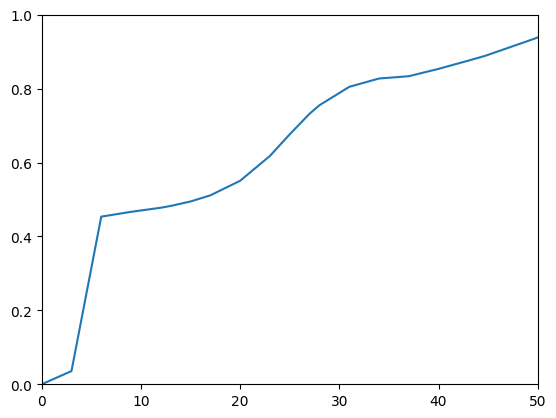

In [25]:
plt.plot(twiss.s,twiss.mux)
plt.ylim(0,1)
plt.xlim(0,50)

In [26]:
twiss.mux[twiss.s > 0]

array([ 0.03575397,  0.45356423,  0.46655954,  0.4776735 ,  0.4776735 ,
        0.48251508,  0.49459501,  0.51123605,  0.55056386,  0.55056386,
        0.61766802,  0.6763007 ,  0.73195981,  0.75505574,  0.80473495,
        0.82726346,  0.8334811 ,  0.85339106,  0.85339106,  0.85339106,
        0.87559244,  0.88903545,  0.93578351,  0.95464571,  0.98468288,
        0.99630672,  1.01495352,  1.01888481,  1.01888481,  1.01888481,
        1.02462501,  1.02870597,  1.04989288,  1.06478843,  1.10978781,
        1.1423047 ,  1.22579638,  1.24748691,  1.24748691,  1.24748691,
        1.27925884,  1.30078008,  1.3826933 ,  1.4144556 ,  1.4586022 ,
        1.47330607,  1.49432135,  1.49838391,  1.49838391,  1.49838391,
        1.50410652,  1.50803143,  1.526711  ,  1.53840751,  1.56880567,
        1.58800449,  1.63580935,  1.64957613,  1.64957613,  1.64957613,
        1.67228937,  1.69019336,  1.79042944,  1.84485166,  1.92076545,
        1.9429245 ,  1.97088605,  1.9757988 ,  1.9757988 ,  1.97

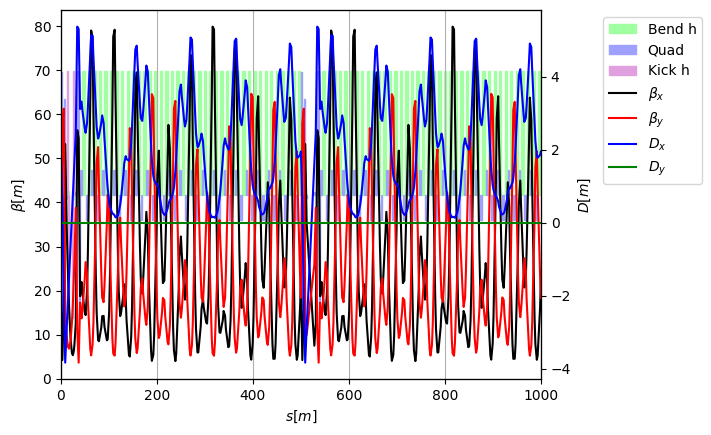

In [27]:
twiss.plot()

(0.0, 40.0)

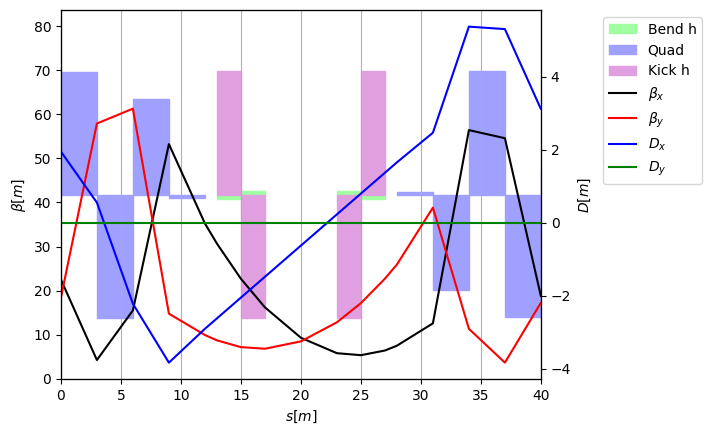

In [28]:
twiss.plot()
plt.xlim(0,40)

And small beta at the extraction

In [29]:
df = line.twiss4d().to_pandas()
extr_idx = df.index[df.name == "extrpt"][0]

In [30]:
# record = line.track(particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')
# record.x[0][extr_idx]

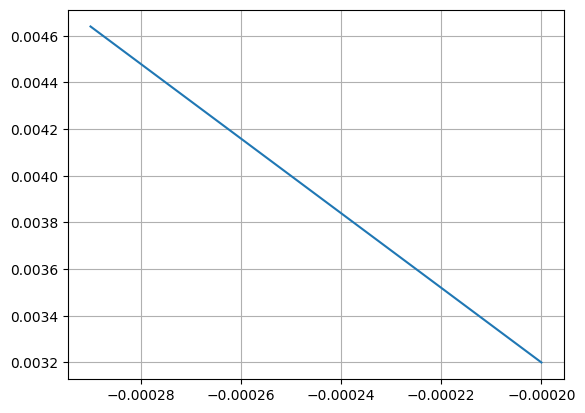

In [31]:
kick_strengths = []
deviations = []
for k in np.arange(-0.0002, -0.0003, -0.00001):
    particles = line.build_particles(num_particles=1)

    line.vars['ext_kicker_angle'] = k

    #line.build_tracker()
    line.track(particles=particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')

    kick_strengths.append(k)
    record = line.record_last_track
    deviations.append(record.x[0][extr_idx])

#p = np.polyfit(deviations, kick_strengths, 1)
#transfer = np.mean(np.array(kick_strengths) / (np.array(deviations) - 0.002))
transfer = np.mean((np.array(deviations) - 0.002) / np.array(kick_strengths))
kick_strength = 0.002 / transfer
#plt.axvline(kick_strength)
plt.plot(kick_strengths, np.array(deviations) - 0.002)
plt.grid()

In [32]:
env['ext_kicker_angle'] = kick_strength

(0.0, 40.0)

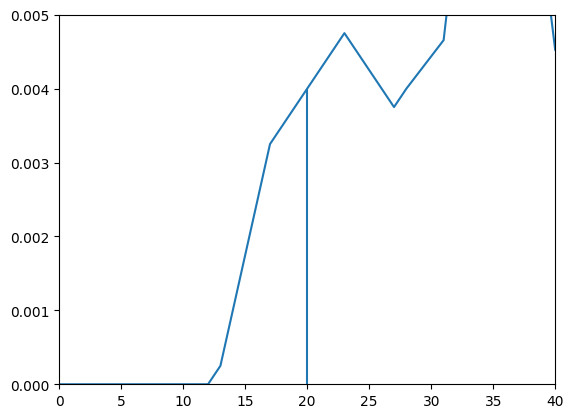

In [33]:
particles = line.build_particles(num_particles=1)
line.track(particles=particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')
record = line.record_last_track
plt.plot(record.s[0], record.x[0])
plt.vlines(20, 0, 0.004)
plt.ylim(0, 5e-3)
plt.xlim(0,40)

In [34]:
num_particles = 1000
nemitt_x = 1e-6/(twiss.beta0*twiss.gamma0)
nemitt_y = nemitt_x
env['ext_kicker_angle'] = 0
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(num_particles)
y_in_sigmas, py_in_sigmas = xp.generate_2D_gaussian(num_particles)
particles = line.build_particles(
            x_norm=x_in_sigmas, px_norm=px_in_sigmas,
            y_norm=y_in_sigmas, py_norm=py_in_sigmas,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y, method = "4d")
env['ext_kicker_angle'] = kick_strength

(0.0, 5.0)

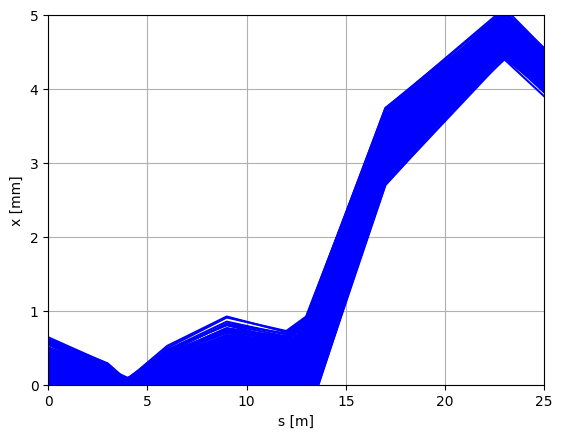

In [35]:
n_turns = 1
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
plt.plot(line.record_last_track.s.T, line.record_last_track.x.T*1e3, 'b')
plt.vlines(twiss.rows["marker_extr"].s, 0, 4, color = "red")
plt.grid()
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.xlim(0,25)
plt.ylim(0,5)

In [36]:
num_particles = 1000
nemitt_x = 1e-6/(twiss.beta0*twiss.gamma0)
nemitt_y = nemitt_x
env['ext_kicker_angle'] = 0
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(num_particles)
y_in_sigmas, py_in_sigmas = xp.generate_2D_gaussian(num_particles)
particles = line.build_particles(
            x_norm=x_in_sigmas, px_norm=px_in_sigmas,
            y_norm=y_in_sigmas, py_norm=py_in_sigmas,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y, method = "4d")
# env['ext_kicker_angle'] = kick_strength

(0.0, 50.0)

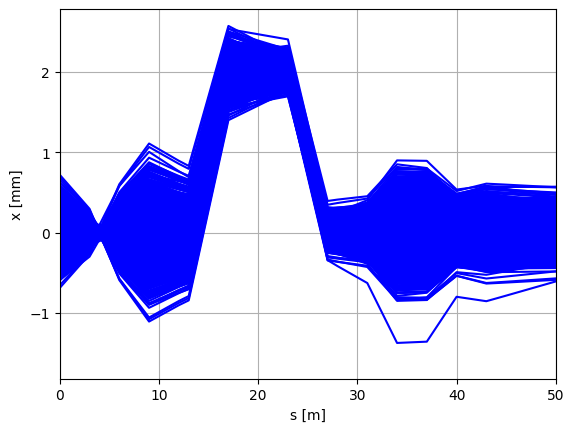

In [37]:
n_turns = 1
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
plt.plot(line.record_last_track.s.T, line.record_last_track.x.T*1e3, 'b')
plt.vlines(twiss.rows["marker_extr"].s, 0, 4, color = "red")
plt.grid()
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.xlim(0,50)

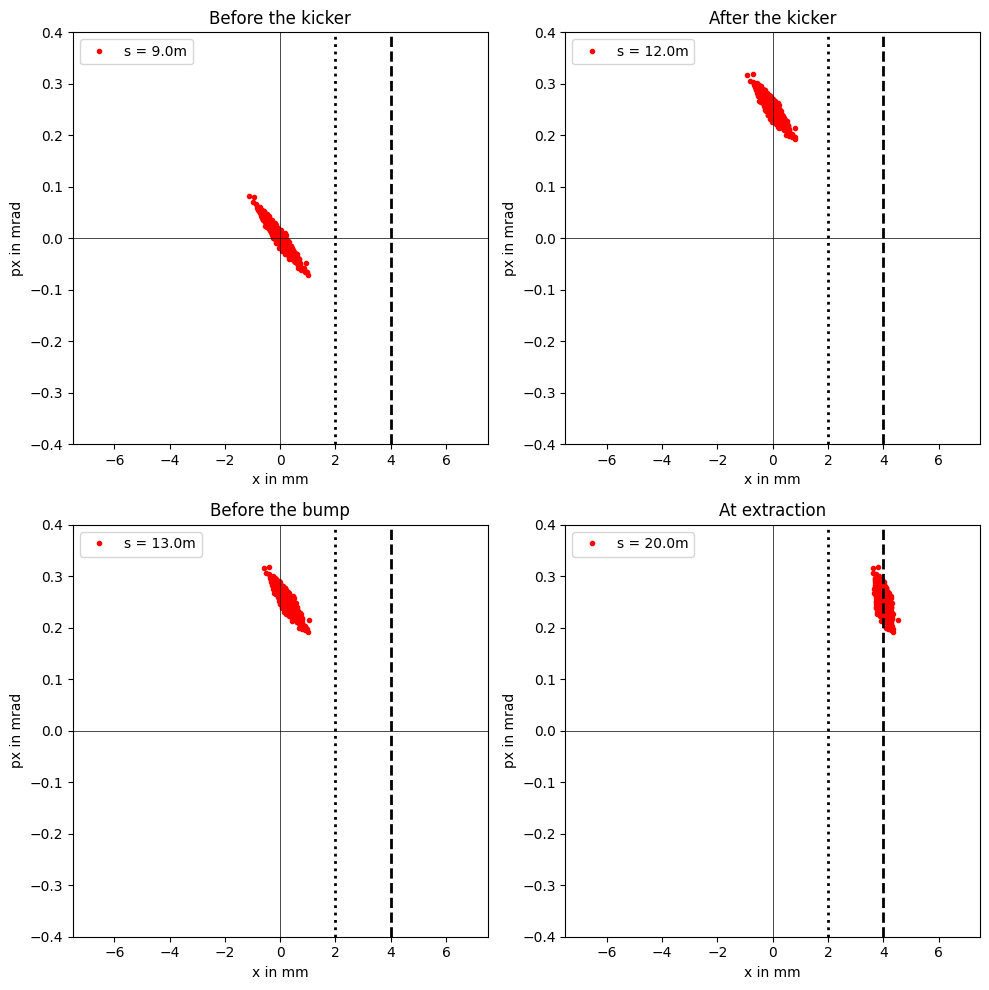

In [38]:
env['ext_kicker_angle'] = kick_strength
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
record = line.record_last_track
s=1000
def set_axes(ax, title=None):
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-0.4, 0.4)
    ax.legend()
    ax.set_xlabel('x in mm')
    ax.set_ylabel('px in mrad')
    # ax.grid()

    ax.axvline(2, color='black', lw=2, ls=':', label=r'\Delta x = 2mm')
    ax.axvline(4, color='black', lw=2, ls='--', label=r'\Delta x = 4mm')
    ax.axvline(0.0, color='black', lw=0.5, ls='-')
    ax.axhline(0.0, color='black', lw=0.5, ls='-')
    if title:
        ax.set_title(title)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# Before the kicker 5
# After the kicker 7
# Before the bump 8
# At extraction 11
record.s = np.round(record.s, 2)
ax[0, 0].plot(record.x[:, 5]*1e3, record.px[:, 5]*1e3, 'r.', label = f's = {record.s[0, 5]}m')
ax[0, 1].plot(record.x[:, 7]*1e3, record.px[:, 7]*1e3, 'r.', label = f's = {record.s[0, 7]}m')
ax[1, 0].plot(record.x[:, 8]*1e3, record.px[:, 8]*1e3, 'r.', label = f's = {record.s[0, 8]}m')
ax[1, 1].plot(record.x[:, 11]*1e3, record.px[:, 11]*1e3, 'r.', label = f's = {record.s[0, 11]}m')
set_axes(ax[0, 0], title='Before the kicker')
set_axes(ax[0, 1], title='After the kicker')
set_axes(ax[1, 0], title='Before the bump')
set_axes(ax[1, 1], title='At extraction')

fig.tight_layout()

In [ ]:
# Export 3D Bdsim model
# once created the model can be run with the command:
# bdsim --file bdsim_model.gmad
# given that bdsim is installed

tw = straight_section1.twiss4d()

file = straight_section1.to_madx_sequence('madx_seq')
with open('madx_seq.seq', 'w') as f:
    f.write(file)

lines = []
lines.append("call, file = 'madx_seq.seq';\n")
lines.append("beam, particle = proton, pc = {}, ex = {}, ey = {};\n".format(pc_GeV, nemitt_x, nemitt_y))
lines.append("use, sequence = madx_seq;\n")
lines.append("select, flag = twiss, clear;\n")
lines.append("select, flag = twiss, column = {NAME, KEYWORD, S, BETX, ALFX, MUX, BETY, ALFY, MUY, X, PX, Y, PY, T, PT, DX, DPX, DY, DPY, WX, PHIX, DMUX, WY, PHIY, DMUY, DDX, DDPX, DDY, DDPY, R11, R12, R21, R22, ENERGY, L, ANGLE, K0L, K0SL, K1L, K1SL, K2L, K2SL, K3L, K3SL, K4L, K4SL, K5L, K5SL, K6L, K6SL, K7L, K7SL, K8L, K8SL, K9L, K9SL, K10L, K10SL, K11L, K11SL, K12L, K12SL, K13L, K13SL, K14L, K14SL, K15L, K15SL, K16L, K16SL, K17L, K17SL, K18L, K18SL, K19L, K19SL, K20L, K20SL, KSI, HKICK, VKICK, TILT, E1, E2, H1, H2, HGAP, FINT, FINTX, VOLT, LAG, FREQ, HARMON, SLOT_ID, ASSEMBLY_ID, MECH_SEP, V_POS, BBCHARGE, XMA, YMA, SIGX, SIGY, LRAD, PARENT, COMMENTS, RE11, RE12, RE13, RE14, RE15, RE16, RE21, RE22, RE23, RE24, RE25, RE26, RE31, RE32, RE33, RE34, RE35, RE36, RE41, RE42, RE43, RE44, RE45, RE46, RE51, RE52, RE53, RE54, RE55, RE56, RE61, RE62, RE63, RE64, RE65, RE66, KMAX, KMIN, CALIB, POLARITY, ALFA, BETA11, BETA12, BETA13, BETA21, BETA22, BETA23, BETA31, BETA32, BETA33, ALFA11, ALFA12, ALFA13, ALFA21, ALFA22, ALFA23, ALFA31, ALFA32, ALFA33, GAMA11, GAMA12, GAMA13, GAMA21, GAMA22, GAMA23, GAMA31, GAMA32, GAMA33, BETA11P, BETA12P, BETA13P, BETA21P, BETA22P, BETA23P, BETA31P, BETA32P, BETA33P, ALFA11P, ALFA12P, ALFA13P, ALFA21P, ALFA22P, ALFA23P, ALFA31P, ALFA32P, ALFA33P, GAMA11P, GAMA12P, GAMA13P, GAMA21P, GAMA22P, GAMA23P, GAMA31P, GAMA32P, GAMA33P, DISP1, DISP2, DISP3, DISP4, DISP1P, DISP2P, DISP3P, DISP4P, DISP1P2, DISP2P2, DISP3P2, DISP4P2, DISP1P3, DISP2P3, DISP3P3, DISP4P3, MU1, MU2, MU3, SIG11, SIG12, SIG13, SIG14, SIG15, SIG16, SIG21, SIG22, SIG23, SIG24, SIG25, SIG26, SIG31, SIG32, SIG33, SIG34, SIG35, SIG36, SIG41, SIG42, SIG43, SIG44, SIG45, SIG46, SIG51, SIG52, SIG53, SIG54, SIG55, SIG56, SIG61, SIG62, SIG63, SIG64, SIG65, SIG66, N1, APERTYPE, APER_1, APER_2};\n")
lines.append("twiss, chrom = true, rmatrix = true, file = 'twiss.tfs', betx = {}, bety = {}, alfx = {}, alfy = {}, mux = {}, muy = {}, dx = {}, dy = {}, ddx = {}, ddy = {};\n".format(tw.betx[0], tw.bety[0], tw.alfx[0], tw.alfy[0], tw.mux[0], tw.muy[0], tw.dx[0], tw.dy[0], tw.ddx[0], tw.ddy[0]))
with open('run.madx', 'w') as f:
    f.writelines(lines)

try:
    from cpymad.madx import Madx
    tw = straight_section1.twiss4d()
    madx = Madx()
    madx.option(echo=True)
    madx.call('run.madx')
except:
    print("cpymad not found")

try:
    import pybdsim
    pybdsim.Convert.MadxTfs2Gmad('twiss.tfs', 'bdsim_model')
except:
    print("pybdsim not found")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2024.11.19 17:56:48      +
  ++++++++++++++++++++++++++++++++++++++++++++
call, file = 'madx_seq.seq';

t_turn_s = 0.0;

lcirc = 920;

lquad = 3;

lbend = 5.0;

k1f = 0.04099169746008972;

k1d = -0.04099169746008972;

qtrim_f = 0;

qtrim_d = 0;

number_of_dipoles = 80;

angle.mb = 0.07853981633974483;

k0.mb := ((angle.mb) / (lbend));

number_of_fodo = 40;

lfodo := ((lcirc) / (number_of_fodo));

kick_angle = -0.001;

kicker_length = 2;

l_ramp = 2;

ksf = 0.0;

ksd = 0.0;

ext_kicker_angle = 0;

ext_kicker_length = 0.5;

lsext = 0.5;

k2f = 0;

k2d = 0;

lss = 40;

f_ss = 2;

k_s11 = 0.20092179801191692;

k_s12 = 0.20266288076949845;

k_s13 = 0.1566121897549735;

k_s14 = 0.0049701877580487774;

k_s21 := (((1.0 / (f_ss)) / (lquad)) / 3.0);

k_s22 := (((1.0 / (f_ss)) / (lquad)) / 3